# Проект: Определение выгодного тарифного плана

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
# отображаем все колонки датафреймов
pd.set_option("display.max_columns", 30)

In [2]:
# загружаем файлы с данными
try:
    calls = pd.read_csv("calls.csv")
    internet = pd.read_csv("internet.csv")
    messages = pd.read_csv("messages.csv")
    tariffs = pd.read_csv("tariffs.csv")
    users = pd.read_csv("users.csv")
except:
    calls = pd.read_csv("/datasets/calls.csv")
    internet = pd.read_csv("/datasets/internet.csv")
    messages = pd.read_csv("/datasets/messages.csv")
    tariffs = pd.read_csv("/datasets/tariffs.csv")
    users = pd.read_csv("/datasets/users.csv")

In [3]:
# создадим функция для ознакомления с таблицами
def info (data):
    data.info()
    display(data.sample(5))
    display(data.describe())

Познакомимся с данными.

In [4]:
info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
191723,1471_526,2018-07-12,5.48,1471
147463,1375_294,2018-09-13,1.85,1375
87798,1219_567,2018-08-31,3.66,1219
49581,1123_600,2018-11-19,11.91,1123
164396,1404_233,2018-06-18,8.13,1404


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [5]:
info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
8816,8816,1030_285,309.86,2018-11-27,1030
80044,80044,1269_56,498.64,2018-12-08,1269
17106,17106,1059_112,521.43,2018-06-22,1059
80553,80553,1271_110,825.44,2018-07-21,1271
146545,146545,1490_288,534.42,2018-06-17,1490


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [6]:
info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
47378,1209_312,2018-11-01,1209
3388,1014_5,2018-07-29,1014
49970,1222_174,2018-12-08,1222
89772,1374_220,2018-06-14,1374
45472,1196_922,2018-11-17,1196


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [7]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [8]:
info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
403,1403,18,NaN,Брянск,Ахмет,Амелин,2018-05-20,ultra
81,1081,42,NaN,Москва,Софья,Терехова,2018-03-25,ultra
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
108,1108,70,NaN,Москва,Рафаил,Болдырев,2018-11-01,smart
486,1486,35,NaN,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

In [9]:
users["city"].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

### Вывод

Данные выглядят достаточно чистыми. Есть несколько проблем, а именно:
- тип данных `object` в столбцах с датами в таблицах calls, messages, internet
- столбец `Unnamed: 0`дублирующий индексы в таблице internet.
- трафик интернета посчитан в мегабайтах, но по условиям плата берется за гигабайты.

## Предобрабока данных и подготовка к анализу

### Предобработка

Удалим ненужный столбец и приведем колонки с датами к нужному формату.

In [10]:
# удаляем столбец Unnamed: 0 в таблице internet
internet.drop("Unnamed: 0", axis=1, inplace=True)
internet.sample(5)

,id,mb_used,session_date,user_id
125075,1421_260,627.80,2018-03-28,1421
73058,1247_96,245.18,2018-10-01,1247
106840,1362_70,218.97,2018-09-18,1362
59946,1204_31,614.96,2018-08-15,1204
36467,1126_414,572.13,2018-08-12,1126


In [11]:
# переводим столбцы с датами в формат datetime
calls["call_date"] = pd.to_datetime(calls["call_date"], format="%Y-%m-%d")
messages["message_date"] = pd.to_datetime(messages["message_date"], format="%Y-%m-%d")
internet["session_date"] = pd.to_datetime(internet["session_date"], format="%Y-%m-%d")
users["reg_date"] = pd.to_datetime(users["reg_date"], format="%Y-%m-%d")
internet["session_date"].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

### Расчеты

Для того чтобы узнать сколько клиент тратит в месяц добавим новый столбец с месяцем совершения операции

In [12]:
# создадим столбец с месяцем для таблиц calls, messages, internet, users
calls["month"] = calls["call_date"].dt.month
messages["month"] = messages["message_date"].dt.month
internet["month"] = internet["session_date"].dt.month
users["month_reg"] = users["reg_date"].dt.month
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg
228,1228,28,NaN,Нижний Новгород,Денис,Алфимов,2018-04-17,smart,4
347,1347,29,NaN,Москва,Лола,Фокина,2018-11-01,ultra,11
172,1172,40,NaN,Санкт-Петербург,Алан,Карасев,2018-05-05,smart,5
208,1208,69,NaN,Пермь,Ева,Сахарова,2018-03-24,ultra,3
16,1016,58,NaN,Омск,Марица,Сазонова,2018-11-21,ultra,11
54,1054,33,NaN,Омск,Кристина,Платонова,2018-03-20,smart,3
125,1125,69,NaN,Волгоград,Сабина,Озерова,2018-09-01,smart,9
438,1438,24,2018-12-24,Екатеринбург,Нателла,Бородина,2018-10-05,smart,10
156,1156,63,NaN,Набережные Челны,Валерий,Галкин,2018-11-12,ultra,11
328,1328,44,NaN,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10


«Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округляем столбец duration таблицы calls.

In [13]:
# округлим звонки до минут и сохраним в новый столбец
calls["duration_ceil"] = np.ceil(calls["duration"])
calls.sample(5)

,id,call_date,duration,user_id,month,duration_ceil
111234,1285_162,2018-05-07,12.31,1285,5,13.0
195055,1478_56,2018-10-18,13.45,1478,10,14.0
61725,1155_533,2018-05-30,9.35,1155,5,10.0
163535,1402_358,2018-05-16,0.27,1402,5,1.0
18659,1051_48,2018-06-19,6.31,1051,6,7.0


In [14]:
# посчитаем количество минут по месяцам и клиентам
calls_group = calls.groupby(["month", "user_id"])["duration_ceil"].sum().reset_index()
display(calls_group.head())
display(calls_group[calls_group["user_id"] == 1000])

,month,user_id,duration_ceil
0,1,1005,95.0
1,1,1032,380.0
2,1,1045,9.0
3,1,1055,551.0
4,1,1071,194.0


,month,user_id,duration_ceil
404,5,1000,159.0
609,6,1000,172.0
853,7,1000,340.0
1142,8,1000,408.0
1479,9,1000,466.0
1849,10,1000,350.0
2260,11,1000,338.0
2704,12,1000,333.0


In [15]:
# считаем количество сообщений по месяцам и клиентам
messages_group = messages.groupby(["month", "user_id"])["id"].count().reset_index()
messages_group.rename(columns={"id": "message_count"}, inplace=True)
display(messages_group.head())
display(messages_group[messages_group["user_id"] == 1000])

,month,user_id,message_count
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16


,month,user_id,message_count
333,5,1000,22
507,6,1000,60
716,7,1000,75
963,8,1000,81
1255,9,1000,57
1573,10,1000,73
1930,11,1000,58
2313,12,1000,70


In [16]:
# посчитаем объем интернет трафика по месяцам и клиентам
internet_group = internet.groupby(["month", "user_id"])["mb_used"].sum().reset_index()
display(internet_group.head())
display(internet_group[internet_group["user_id"] == 1000])

,month,user_id,mb_used
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34


,month,user_id,mb_used
404,5,1000,2253.49
611,6,1000,23233.77
858,7,1000,14003.64
1149,8,1000,14055.93
1489,9,1000,14568.91
1863,10,1000,14702.49
2279,11,1000,14756.47
2728,12,1000,9817.61


In [17]:
# объединим таблицы
total = calls_group.merge(messages_group, how="outer", on=["month", "user_id"])
total = total.merge(internet_group, how="outer", on=["month", "user_id"])
total = users.merge(total, how="outer", on=["user_id"])
total = total.merge(tariffs, how="outer", left_on=["tariff"], right_on=["tariff_name"])
total

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month,duration_ceil,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,5.0,159.0,22.0,2253.49,1000,30720,3000,1950,150,1,1,ultra
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,6.0,172.0,60.0,23233.77,1000,30720,3000,1950,150,1,1,ultra
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,7.0,340.0,75.0,14003.64,1000,30720,3000,1950,150,1,1,ultra
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,8.0,408.0,81.0,14055.93,1000,30720,3000,1950,150,1,1,ultra
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9.0,466.0,57.0,14568.91,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,10.0,247.0,42.0,20579.36,50,15360,500,550,200,3,3,smart
3212,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,9.0,70.0,11.0,1845.75,50,15360,500,550,200,3,3,smart
3213,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,10.0,449.0,48.0,17788.51,50,15360,500,550,200,3,3,smart
3214,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,11.0,612.0,59.0,17963.31,50,15360,500,550,200,3,3,smart


Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
Поэтому переведем Мб в Гб и округлим до целых чисел в большую сторону.

In [18]:
# переведем Мб в Гб
total["gb_used"] = np.ceil(total["mb_used"] / 1024)
total["gb_per_month_included"] = total["mb_per_month_included"] / 1024

display(total["gb_used"].sample(5))
display(total["gb_per_month_included"].sample(5))

1810    16.0
2625    10.0
714      NaN
514     25.0
808     31.0
Name: gb_used, dtype: float64

3180    15.0
32      30.0
1971    15.0
1996    15.0
2816    15.0
Name: gb_per_month_included, dtype: float64

После слияния в таблицах могли появится аномалии. Посмотрим общую информацию.

In [19]:
info(total)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 23 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null object
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month_reg                3216 non-null int64
month                    3214 non-null float64
duration_ceil            3174 non-null float64
message_count            2717 non-null float64
mb_used                  3203 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute   

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month,duration_ceil,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included
3121,1481,70,NaN,Москва,Клавдия,Чижова,2018-02-26,smart,2,2.0,36.0,6.0,2745.82,50,15360,500,550,200,3,3,smart,3.0,15.0
3054,1468,29,NaN,Тамбов,Иван,Авдышев,2018-02-11,smart,2,2.0,137.0,5.0,9080.94,50,15360,500,550,200,3,3,smart,9.0,15.0
2960,1443,21,NaN,Казань,Иван,Афинин,2018-09-17,smart,9,9.0,407.0,10.0,3513.25,50,15360,500,550,200,3,3,smart,4.0,15.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9.0,466.0,57.0,14568.91,1000,30720,3000,1950,150,1,1,ultra,15.0,30.0
2832,1419,19,NaN,Новороссийск,Эльмира,Яшина,2018-07-19,smart,7,12.0,538.0,49.0,17368.59,50,15360,500,550,200,3,3,smart,17.0,15.0


,user_id,age,month_reg,month,duration_ceil,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included
count,3216.000000,3216.000000,3216.000000,3214.000000,3174.000000,2717.000000,3203.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3203.000000,3216.000000
mean,1251.588930,46.643968,4.723570,8.317362,456.931632,45.283769,17266.708626,341.262438,20069.253731,1266.480100,979.228856,184.670398,2.386816,2.386816,17.358414,19.598881
std,144.645928,16.581233,2.912794,2.905413,238.031270,35.051363,7516.356902,438.092669,7083.266729,1152.875444,645.610249,23.057509,0.922300,0.922300,7.343379,6.917253
min,1000.000000,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,15.000000
25%,1125.000000,32.000000,2.000000,6.000000,290.000000,19.000000,12526.905000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,13.000000,15.000000
50%,1253.000000,46.000000,4.000000,9.000000,447.000000,38.000000,16963.110000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,17.000000,15.000000
75%,1378.250000,62.000000,7.000000,11.000000,592.000000,63.000000,21432.175000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,21.000000,30.000000
max,1499.000000,75.000000,12.000000,12.000000,1673.000000,224.000000,49745.690000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,49.000000,30.000000


После слияния появились пропущенные значения. Посмотрим пропуски в столбце с месяцем. Так же видим что появились пропуски в столбцах со звонками, сообщениями и интернетом. Это произошло потому что в каком-то конкретном месяце абонент не пользовался какой-то из услуг. Заменим пропущенные значения нулями.

In [20]:
total[pd.isnull(total["month"])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month,duration_ceil,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included
243,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1,ultra,NaN,30.0
2619,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,NaN,NaN,NaN,NaN,50,15360,500,550,200,3,3,smart,NaN,15.0


После объединения таблиц у нас появилось 2 пользователя, которые по всей видимости не пользовались услугами, и как видим по таблице ушли с тарифа в том же месяце что и пришли. Скорее всего абонплату они все равно должны были бы заплатить, поэтому оставим их в таблице, заполнив пропуски в месяце. 

In [21]:
# заполним пропуски в месяце у пользователей с нулевой активностью
total["month"] = total["month"].fillna(12)

# заполним NaN в сообщениях, звонках и трафике на 0
total["duration_ceil"] = total["duration_ceil"].fillna(0)
total["message_count"] = total["message_count"].fillna(0)
total["gb_used"] = total["gb_used"].fillna(0)

# переведем столбец с месяцем в целочисленный формат
total["month"] = total["month"].astype("int")

Можем приступить к расчету выручки.

Описание тарифов:
- Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
- Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Посчитаем сначала превышение лимита у абонентов, а затем выручку.

In [22]:
# посчитаем звонки, сообщения и трафик сверхлимита
total["min_over_limit"] = total["duration_ceil"] - total["minutes_included"]
total["masseges_over_limit"] = total["message_count"] - total["messages_included"]
total["internet_over_limit"] = total["gb_used"] - total["gb_per_month_included"]

# уберем отрицательные значения, там где человек недовыбрал тариф
total["min_over_limit"] = total["min_over_limit"].where(total["min_over_limit"] > 0, 0)
total["masseges_over_limit"] = total["masseges_over_limit"].where(total["masseges_over_limit"] > 0, 0)
total["internet_over_limit"] = total["internet_over_limit"].where(total["internet_over_limit"] > 0, 0)

# посчитаем помесячную выручку
total["revenue"] = (total["min_over_limit"] * total["rub_per_minute"] + 
                    total["masseges_over_limit"] * total["rub_per_message"] + 
                    total["internet_over_limit"] * total["rub_per_gb"] +
                    total["rub_monthly_fee"]
                   )
total.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_reg,month,duration_ceil,message_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included,min_over_limit,masseges_over_limit,internet_over_limit,revenue
1318,1068,34,NaN,Москва,Ким,Демьянов,2018-07-16,smart,7,9,564.0,21.0,21063.37,50,15360,500,550,200,3,3,smart,21.0,15.0,64.0,0.0,6.0,1942.0
2277,1284,62,NaN,Волгоград,Евфросинья,Петухова,2018-03-16,smart,3,3,261.0,15.0,6572.59,50,15360,500,550,200,3,3,smart,7.0,15.0,0.0,0.0,0.0,550.0
1364,1077,18,NaN,Москва,Марица,Кольцова,2018-10-23,smart,10,11,686.0,36.0,18981.92,50,15360,500,550,200,3,3,smart,19.0,15.0,186.0,0.0,4.0,1908.0
940,1469,41,NaN,Сочи,Аксён,Абалкин,2018-07-06,ultra,7,11,795.0,0.0,35501.97,1000,30720,3000,1950,150,1,1,ultra,35.0,30.0,0.0,0.0,5.0,2700.0
2581,1358,64,NaN,Ставрополь,Демьян,Логинов,2018-02-21,smart,2,6,660.0,55.0,10806.64,50,15360,500,550,200,3,3,smart,11.0,15.0,160.0,5.0,0.0,1045.0


Посмотрим сколько абонетов каждого тарифа у нас в выборке.

In [23]:
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

### Вывод

Для выполнения задания мы сначала перевели столбцы с датами в формат времени, а затем выделили столбец с месяцем совершения операциии, сгрупировали данные по клиенту и месяцу.
Объеденив все данные в одну таблицу мы выявили двух абонентов, которые ушли с тарифа в том же месяце, что и зарегистрировались, чтобы учесть выручку с них - заменили пропуска на месяц регистрации. Далее мы смогли рассчитать помесячные расходы каждого клиента, с учетом превышений тарифа и можем приступить непосредственно к анализу данных.

Также мы узнали что абонентов тарифа Смарт у нас более чем в два раза больше чем абонентов тарифа Ультра.

## Анализ данных

### Таблицы, метрики

Для анализа нам не потребуются все столбцы, поэтому создадим новую таблицу, а ее разделим на 2 - по тарифам.

In [24]:
# создадим таблицу
total_1 = total[["user_id", 'month', 'age', "city",'duration_ceil', 'message_count', 'gb_used', 'revenue', 'tariff']]
total_1.sample(5)

,user_id,month,age,city,duration_ceil,message_count,gb_used,revenue,tariff
377,1222,11,44,Уфа,1027.0,114.0,22.0,1950.0,ultra
1150,1034,9,66,Вологда,730.0,37.0,17.0,1640.0,smart
2616,1370,8,48,Новороссийск,123.0,0.0,19.0,1350.0,smart
3013,1457,7,35,Саратов,472.0,28.0,15.0,550.0,smart
40,1021,4,61,Краснодар,90.0,13.0,5.0,1950.0,ultra


In [25]:
total_smart = total_1.query('tariff == "smart"')

In [26]:
total_ultra = total_1.query('tariff == "ultra"')

In [27]:
# проверим что все строки попали в наши срезы
print(len(total_smart)+len(total_ultra))

3216


Посчитаем помесячно и годовые среднее, дисперсию и стандартное отклонение для каждого тарифа. В задании указано сделать это для минут, сообщений и трафика, но расчитаем также эти данные для выручки, т.к. при проверке гипотез нам нужны будут именно средние значения.

In [28]:
# сводная для тарифа смарт
total_smart_1 = total_smart.pivot_table(index="month", values=("duration_ceil", "message_count", "gb_used", "revenue"), aggfunc=('mean', 'var', 'std'))
total_smart_1.columns = ["duration_mean", "duration_std", "duration_var", "gb_mean", "gb_std", "gb_var", "message_mean", "message_std", "message_var", "revenue_mean", "revenue_std", "revenue_var"]
total_smart_1

,duration_mean,duration_std,duration_var,gb_mean,gb_std,gb_var,message_mean,message_std,message_var,revenue_mean,revenue_std,revenue_var
month,,,,,,,,,,,,
1,203.852941,154.231454,23787.341355,8.735294,6.277950,39.412656,18.235294,16.197753,262.367201,721.323529,438.766641,1.925162e+05
2,298.689655,190.820041,36412.287961,11.844828,6.095157,37.150938,24.086207,21.750809,473.097701,827.603448,540.702011,2.923587e+05
3,390.051948,191.893604,36823.155161,15.233766,5.705252,32.549897,31.857143,26.804710,718.492481,1164.623377,698.025091,4.872390e+05
4,367.133929,186.489161,34778.207127,13.625000,5.594600,31.299550,30.741071,24.538532,602.139559,963.089286,562.064543,3.159166e+05
5,387.361702,186.601343,34820.061094,15.907801,5.862594,34.370010,33.773050,27.036845,730.990983,1197.510638,722.973153,5.226902e+05
6,395.640244,175.336587,30742.918861,15.951220,5.649046,31.911716,33.402439,28.404337,806.806374,1204.018293,745.738005,5.561252e+05
7,408.353234,179.583601,32250.269602,15.875622,5.780956,33.419453,33.751244,28.282288,799.887811,1223.950249,738.470208,5.453382e+05
8,421.468085,186.530382,34793.583379,16.736170,5.480986,30.041207,33.638298,28.952677,838.257501,1320.595745,792.224318,6.276194e+05
9,428.611538,183.126576,33535.342723,16.392308,5.087643,25.884110,33.638462,28.117927,790.617820,1249.946154,732.590262,5.366885e+05


In [29]:
np.mean(total_smart[["duration_ceil", "message_count", "gb_used", "revenue"]])

duration_ceil     417.747534
message_count      33.369058
gb_used            16.321525
revenue          1289.641704
dtype: float64

In [30]:
np.var(total_smart[["duration_ceil", "message_count", "gb_used", "revenue"]], ddof=1)

duration_ceil     36281.393836
message_count       796.955256
gb_used              33.133453
revenue          669730.763895
dtype: float64

In [31]:
np.std(total_smart[["duration_ceil", "message_count", "gb_used", "revenue"]], ddof=1)

duration_ceil    190.476754
message_count     28.230396
gb_used            5.756167
revenue          818.370799
dtype: float64

В среднем абонентам тарифа смарт необходимо 417 мин разговора в месяц, причем эта цифра с начала года увеличилась более чем в два раза. Что касается интернета то трафик тоже значительно вырос с 8Гб в среднем в январе до 18Гб в декабре, если говорить в среднем по году то абоненту требуется 16Гб трафика, что превышаяет бесплатный лимит в 15Гб по этому тарифу. По сообщениям потребность выросла тоже почти в 2 раза, до 35 сообщений в месяц. В целом абоненты тарифа смарт укладываются в бесплатный лимит по звонкам и сообщениям, но есть тенденция к увеличению потребностей.

In [32]:
# сводная для тарифа ультра
total_ultra_1 = total_ultra.pivot_table(index="month", values=("duration_ceil", "message_count", "gb_used", "revenue"), aggfunc=('mean', 'var', 'std'))
total_ultra_1.columns = ["duration_mean", "duration_std", "duration_var", "gb_mean", "gb_std", "gb_var", "message_mean", "message_std", "message_var", "revenue_mean", "revenue_std", "revenue_var"]
total_ultra_1

,duration_mean,duration_std,duration_var,gb_mean,gb_std,gb_var,message_mean,message_std,message_var,revenue_mean,revenue_std,revenue_var
month,,,,,,,,,,,,
1,428.111111,269.757968,72769.361111,13.222222,6.666667,44.444444,33.777778,30.670742,940.694444,1950.000000,0.000000,0.000000
2,297.125000,296.512528,87919.679348,12.000000,10.446551,109.130435,21.958333,26.773574,716.824275,1975.000000,84.698955,7173.913043
3,489.648649,333.743765,111384.900901,17.648649,10.693238,114.345345,32.297297,41.621886,1732.381381,2014.864865,207.787573,43175.675676
4,458.018182,267.682405,71653.870034,16.963636,9.457436,89.443098,31.563636,37.513831,1407.287542,2001.818182,196.252775,38515.151515
5,510.328358,289.603511,83870.193578,19.373134,9.779130,95.631389,37.850746,40.306874,1624.644052,2059.701493,403.323204,162669.606513
6,479.702381,302.549081,91535.946500,18.940476,9.077114,82.394005,41.726190,44.567899,1986.297619,2039.285714,315.948698,99823.580034
7,545.791209,307.119322,94322.278144,20.505495,9.819905,96.430525,49.846154,48.703621,2372.042735,2118.131868,446.001774,198917.582418
8,510.775701,312.980026,97956.496385,19.598131,10.254184,105.148298,48.439252,46.601923,2171.739199,2083.177570,399.701771,159761.505907
9,539.443478,325.141162,105716.775286,19.243478,9.287410,86.255988,52.286957,46.398874,2152.855530,2024.347826,246.854352,60937.070938


In [33]:
np.mean(total_ultra[["duration_ceil", "message_count", "gb_used", "revenue"]])

duration_ceil     526.089249
message_count      49.313387
gb_used            19.474645
revenue          2070.030426
dtype: float64

In [34]:
np.var(total_ultra[["duration_ceil", "message_count", "gb_used", "revenue"]], ddof=1)

duration_ceil    101052.493549
message_count      2285.417425
gb_used              97.378544
revenue          141387.714809
dtype: float64

In [35]:
np.std(total_ultra[["duration_ceil", "message_count", "gb_used", "revenue"]], ddof=1)

duration_ceil    317.887549
message_count     47.806040
gb_used            9.868057
revenue          376.015578
dtype: float64

Абоненты тарифа Ультра тоже стали больше звонить, но количество минут выросло не так стремительно, как в тарифе Смарт (с 428минут в январе до 588минут в декабре). Среднемесячное количество выговоренных минут за год - 526мин. По трафику видим что абоненты также чаще стали пользоваться интернетом(с 13Гб в начале года до 21,5Гб в конце). Почти в два раза увеличилось среднемесячное количество отправленных смс(до 60смс в месяц в конце года).

### Графики

Картина по средним показателям в целом ясна, но нужно проверить есть ли в наших данных выбросы, т.к.они могут сильно искажать картину.

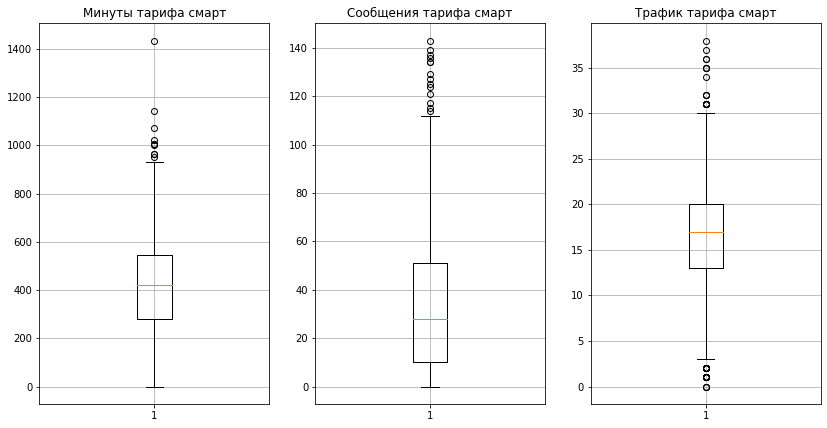

In [36]:
# построим боксплоты
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,7))

ax1.boxplot(total_smart["duration_ceil"])
ax1.set_title("Минуты тарифа смарт")
ax1.grid()
ax2.boxplot(total_smart["message_count"])
ax2.set_title("Сообщения тарифа смарт")
ax2.grid()
ax3.boxplot(total_smart["gb_used"])
ax3.set_title("Трафик тарифа смарт")
ax3.grid()

Выбросы есть, но они в целом не искажают картину, поэтому будем считать среднее удачным показателем для характеристики поведения абонентов тарифа Смарт.

Посмотрим на выбросы в выборке тарифа Ультра.

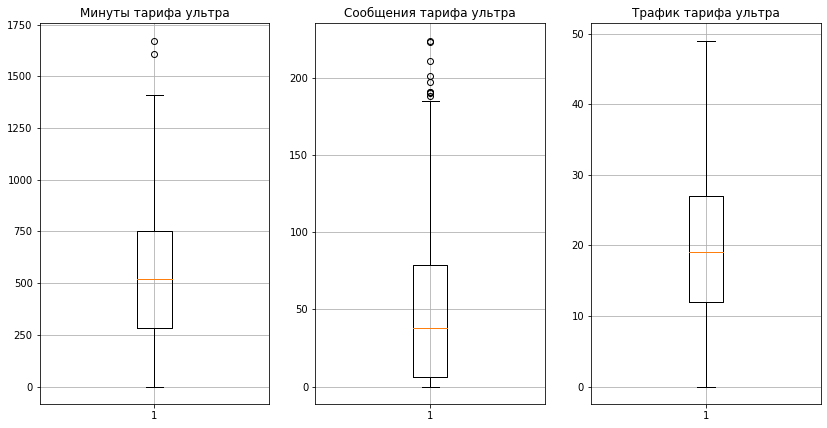

In [37]:
# построим боксплоты
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,7))

ax1.boxplot(total_ultra["duration_ceil"])
ax1.set_title("Минуты тарифа ультра")
ax1.grid()
ax2.boxplot(total_ultra["message_count"])
ax2.set_title("Сообщения тарифа ультра")
ax2.grid()
ax3.boxplot(total_ultra["gb_used"])
ax3.set_title("Трафик тарифа ультра")
ax3.grid()

Тоже картина вцелом хорошая. Выбросов очень мало.

Построим гистограммы и посмотрим частоту распределения абонентов по объему выбраных услуг.

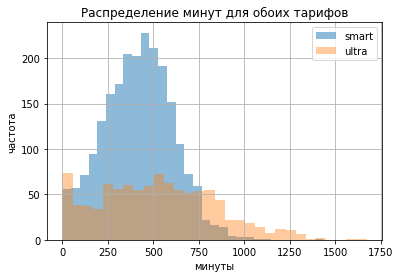

In [38]:
# совмещенная гистограмма для минут
plt.hist(total_smart["duration_ceil"], label="smart", alpha=0.5, bins=30);
plt.hist(total_ultra["duration_ceil"], label="ultra", alpha=0.4, bins=30);

plt.xlabel("минуты")
plt.ylabel("частота")
plt.title("Распределение минут для обоих тарифов")
plt.grid()
plt.legend()
plt.show();

Основная масса абонентов тарифа Смарт укладывается в бесплатные 500мин, что подтверждает и расчет среднего. В тарифе Ультра абоненты тоже тратят в целом до 750мин в месяц при лимите в 3000мин. 

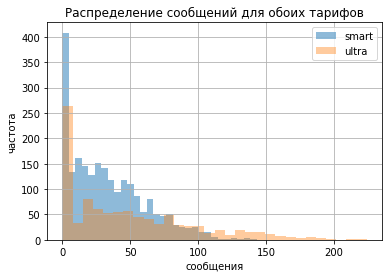

In [39]:
# совмещенная гистограмма по сообщениям
plt.hist(total_smart["message_count"], label="smart", alpha=0.5, bins=30);
plt.hist(total_ultra["message_count"], label="ultra", alpha=0.4, bins=30);

plt.xlabel("сообщения")
plt.ylabel("частота")
plt.title("Распределение сообщений для обоих тарифов")
plt.grid()
plt.legend()
plt.show();

На гистограмме видно, что есть много абонентов, которые отправляют мало сообщений. Причем в обоих тарифах.

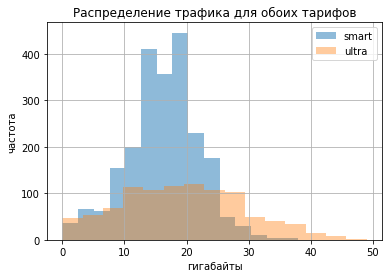

In [40]:
# совмещенная гистограмма по трафику
plt.hist(total_smart["gb_used"], label="smart", alpha=0.5, bins=15);
plt.hist(total_ultra["gb_used"], label="ultra", alpha=0.4, bins=15);

plt.xlabel("гигабайты")
plt.ylabel("частота")
plt.title("Распределение трафика для обоих тарифов")
plt.grid()
plt.legend()
plt.show();

Как видим абоненты тарифа Смарт превышают бесплатный лимит в 15Гб, тогда как большая часть абонентов Ультра свои 30Гб даже не выбирают.

### Дополнительное исследование

В условии не прямо не указано исследовать выручку, но как мне кажется это для компании будет интересно.

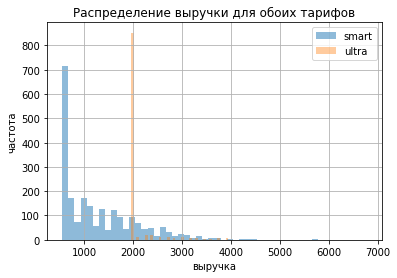

In [41]:
# совмещенная гистограмма по выручке
plt.hist(total_smart["revenue"], label="smart", alpha=0.5, bins=50);
plt.hist(total_ultra["revenue"], label="ultra", alpha=0.4, bins=50);

plt.xlabel("выручка")
plt.ylabel("частота")
plt.title("Распределение выручки для обоих тарифов")
plt.grid()
plt.legend()
plt.show();

Большинство абонентов тарифа Ультра платят только абонплату(высокий пик на отметке 1950р), по Смарту тоже есть пик на уровне абонплаты - 550р, но многие абоненты этого тарифа все же переплачивают.

### Вывод

В среднем абонентам тарифа ультра необходимо 417 мин разговора в месяц, причем эта цифра с начала года увеличилась более чем в два раза. Получается абоненты этого тарифа укладываются в бесплатный лимит. Что касается интернета то трафик тоже значительно вырос с 8Гб в среднем в январе до 18Гб в декабре, если говорить по году то абоненту требуется 16Гб трафика, что превышаяет бесплатный лимит в 15Гб по этому тарифу. По сообщениям потребность выросла тоже почти в 2 раза, до 35 сообщений в месяц. В целом абоненты тарифа смарт укладываются в бесплатный лимит по звонкам и сообщениям, но есть тенденция к увеличению потребностей.
Абоненты тарифа Ультра тоже стали больше звонить, но количество минут выросло не так стремительно, как в тарифе Смарт (с 428минут в январе до 588минут в декабре). Странный провал по среднему количеству минут в феврале в этом тарифе. Среднемесячное количество выговоренных минут за год - 526мин. Это при том что бесплатный месячный объем - 3000мин!!! По трафику видим, что абоненты также чаще стали пользоваться интернетом(с 13Гб в начале года до 21,5Гб в конце). Почти в два раза увеличилось среднемесячное количество отправленных смс(до 60смс в месяц в конце года). 
По выручке можно сказать, что абоненты тарифа Ультра в основном платят только абонплату, в то время как абоненты тарифа Смарт часто превышают лимит трафика и поэтому должны доплачивать.

## Проверка гипотез

На данном этапе нам нужно проверить 2 гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.
А так же пояснить как формулировали нулевую и альтернативную гипотезы; какой критерий использовали для проверки гипотез и почему.

### Гипотеза о различии средних выручек

Посчитаем для начала равные ли у нас дисперсии для выборок

In [42]:
print("Дисперсия по тарифу Смарт:", np.var(total_smart["revenue"]))
print("Дисперсия по тарифу Ультра:", np.var(total_ultra["revenue"]))

Дисперсия по тарифу Смарт: 669430.4361979931
Дисперсия по тарифу Ультра: 141244.31956107615


Дисперсии отличаются почти в 5 раз поэтому параметр `equal_var` поставим `False`.

`alpha` выберем равным **0,05**, т.к.мне кажется, для этой ситуации сверхточность нам ни к чему.

Теперь нужно сформулировать нулевую и альтернативную гипотезу.
Т.к.по теории мы знаем, что нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства она будет звучать так: **"Средняя выручка пользователей тарифов Смарт и Ультра равны"**. Альтернативная гипотеза: **"Средняя выручка пользователей тарифов Смарт и Ультра различаются"**. Так как мы не знаем в какую сторону проверять различие тест будет двухсторонним.

In [43]:
alpha = 0.05
results = st.ttest_ind(
    total_smart["revenue"], 
    total_ultra["revenue"], equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве двух выручек не подтвердилась, поэтому принимаем альтернативную гипотезу, о различии средних выручек. Средняя выручка пользователей тарифов Смарт и Ультра **различаются**.

### Гипотеза о различии средней выручки пользователей Москвы и других регионов

Вторая гипотеза. которую нужно проверить звучит так: "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

`alpha` оставим на уровне **0.05**.

У нас нет данных отдельно по Москве и остальным городам, чтобы расчитать средние выручки. поэтому сначала сделаем срезы.

In [44]:
total_moscow = total_1.query('city == "Москва"')
total_other = total_1.query('city != "Москва"')

# проверим что все строки попали в наши срезы
print(len(total_moscow)+len(total_other))

3216


In [45]:
print("Дисперсия по Москве:", np.var(total_moscow["revenue"]))
print("Дисперсия по другим городам:", np.var(total_other["revenue"]))

Дисперсия по Москве: 564710.7117467273
Дисперсия по другим городам: 653818.4925923498


   Как видим дисперсия отличается не сильно. поэтому параметр `equal_var` указывать не будем(по умолчанию он принимает значение `True`)

Осталось сформулировать нулевую и альтернативную гипотезу. Нулевая гипотеза будет звучать так: **"средняя выручка пользователей из Москвы равна выручке пользователей из других регионов"**. Альтернативная тогда - **"средние выручки по Москве и регионам отличаются"**.

In [46]:
alpha = 0.05
results = st.ttest_ind(
    total_moscow["revenue"], 
    total_other["revenue"])

print('p-значение:', results.pvalue)
if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу. Полученный результат говорит о том, что средние значения выручки статистически значимо **не отличаются**.

### Вывод

Мы проверили две гипотезы. По итогам можем сказать, что средние выручки разных тарифов статистически значимо различаются, а средние выручки абонентов Москвы и других регионов - нет.

## Общий вывод

На входе мы получили 4 таблицы с данными о 500-х абонентах оператора "Мегалайн" и о совершенных ими действиях(звонках, сообщениях, трафике интернета). В пятой таблице хранятся данные о тарифах оператора - Смарт и Ультра.

**Размер анализируемых групп:**
- smart    351 чел
- ultra    149 чел

Данные в основном поступили в чистом виде. На этапе предобработки мы лишь заменили тип данных в нескольких столбцах с датами, удалили ненужный столбец из таблицы internet.

**Результаты анализа:**
- Абоненты тарифа Смарт часто переплачивают за счет того, что им нехватает бесплатного лимита по интернету.
- Абоненты тарифа Ультра в основном платят только абонплату, т.к.укладываются в бесплатные лимиты.
- Смс - непопулярная ныне услуга. Многие либо вообще не пользуются ею, либо очень редко.
- Вобщем заметна тенденция к увеличению количества потребляемых услуг для обоих тарифов, но для тарифа Смарт быстрее.
- Возможно некоторым абонентам тарифа Ультра было бы даже выгодно перейти на тариф Смарт, т.к. средние показатели лежат не так далеко от лимитов этого тарифа.

**Результаты проверки гипотез:**
- Средняя выручка пользователей тарифов Смарт и Ультра статистически значимо **различаются**.
- Средняя выручка пользователей из Москвы и других регионов статистически значимо **не различаются**.

**Рекомендации:**

Коммерческому отделу стоит скорректировать рекламный бюджет в сторону тарифа Смарт, т.к.он более выгоден для абонентов в плане привлекательности абонплаты, при этом он приносит больше выручки, т.к.абоненты часто переплачивают сверх лимита за счет трафика.